# Q5. Sulav Shrestha

# `MultiClass SVM` (3) using custom trained `fasttext` embeddings

In [22]:
import numpy as np
import pandas as pd
import re
import fasttext.util
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import fasttext
from imblearn.under_sampling import RandomUnderSampler

# from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from itertools import cycle
from lime.lime_text import LimeTextExplainer
import random



In [23]:
df = pd.read_csv("data/Sentiment_Data.csv", encoding='latin-1')

In [24]:
df.head()

Tweet Sentiment
0  @_angelica_toy Happy Anniversary!!!....The Day...  Mild_Pos
1  @McfarlaneGlenda Happy Anniversary!!!....The D...  Mild_Pos
2  @thevivafrei @JustinTrudeau Happy Anniversary!...  Mild_Pos
3  @NChartierET Happy Anniversary!!!....The Day t...  Mild_Pos
4  @tabithapeters05 Happy Anniversary!!!....The D...  Mild_Pos

In [25]:
df.shape

(451332, 2)

# Preprocessing and cleaning

## Null values

In [26]:
null_vals = df.isnull().sum()
null_vals

Tweet        1
Sentiment    0
dtype: int64

In [27]:
df_cleaned = df.dropna()
df_cleaned.isnull().sum()

Tweet        0
Sentiment    0
dtype: int64

In [28]:
sentiment_counts = df['Sentiment'].value_counts()
sentiment_counts

Sentiment
Strong_Pos    233700
Neutral        77016
Mild_Pos       64004
Strong_Neg     42556
Mild_Neg       34056
Name: count, dtype: int64

## First of all lets convert the Mild and Strong positive and negative reaction to one positive and negative reaction

In [29]:
df_cleaned = df_cleaned.copy()
df_cleaned['Sentiment'] = df_cleaned['Sentiment'].replace({
    'Mild_Pos': 'Positive',
    'Strong_Pos': 'Positive',
    'Mild_Neg': 'Negative',
    'Strong_Neg': 'Negative'
})

In [30]:
sentiment_counts = df_cleaned['Sentiment'].value_counts()
sentiment_counts

Sentiment
Positive    297704
Neutral      77015
Negative     76612
Name: count, dtype: int64

<Axes: xlabel='Sentiment', ylabel='Count'>

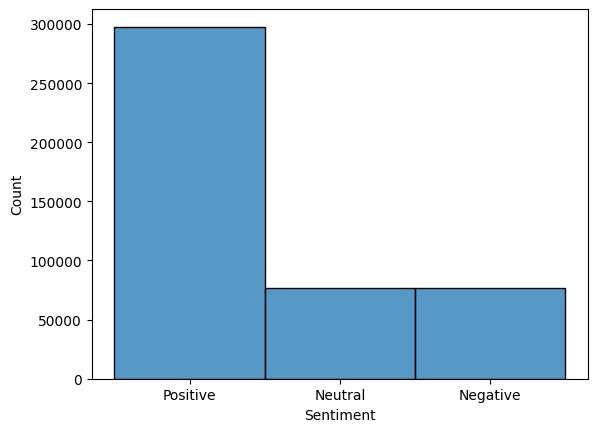

In [31]:
sns.histplot(df_cleaned['Sentiment'])

## We can see the data is not balanced, it needs undersampling which we will perform after train test split later because, we will not undersample the test data

## AS we can see there are lots of hashtags, mentions(@), links, and special characters in the data. So we need to remove them as they they do not impose any particular purpose in our data

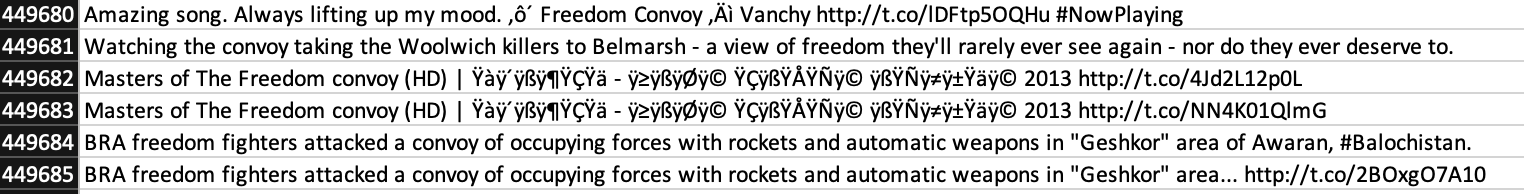

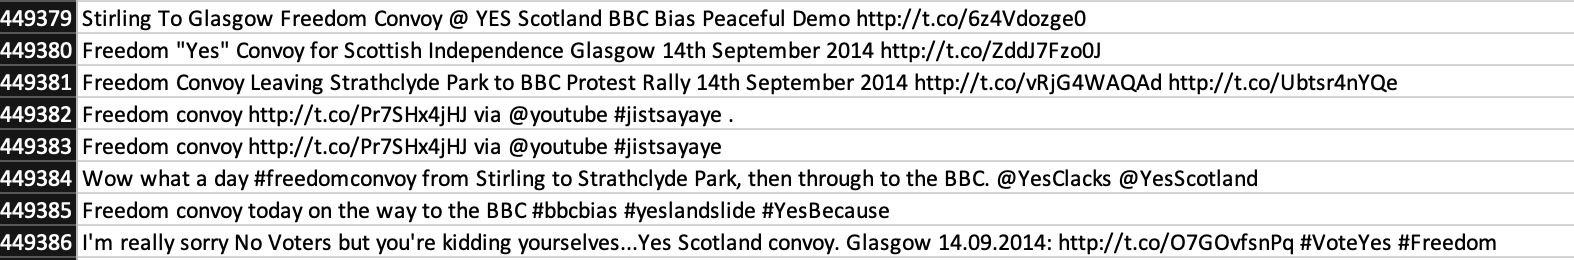

In [32]:
def clean_data(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet, flags=re.MULTILINE) #* Links
    tweet = re.sub(r'\@\w+|\#','', tweet) #* Mentions and Hashtags
    tweet = re.sub(r'[^a-z\s]', '', tweet) #* Keeping only letters and spaces
    return tweet

df_cleaned['Tweet'] = df_cleaned['Tweet'].apply(clean_data)

df_cleaned.head(30)

Tweet Sentiment
0    happy anniversarythe day the freedumb died in...  Positive
1    happy anniversarythe day the freedumb died in...  Positive
2     happy anniversarythe day the freedumb died i...  Positive
3    happy anniversarythe day the freedumb died in...  Positive
4    happy anniversarythe day the freedumb died in...  Positive
5    happy anniversarythe day the freedumb died in...  Positive
6      happy anniversarythe day the freedumb died ...  Positive
7     happy anniversarythe day the freedumb died i...  Positive
8                     freedom convoy as inkblot test   Positive
9     happy anniversarythe day the freedumb died i...  Positive
10    happy anniversarythe day the freedumb died i...  Positive
11    happy anniversarythe day the freedumb died i...  Positive
12   happy anniversarythe day the freedumb died in...  Positive
13   well its pretty easy to see what their agenda...  Positive
14   happy anniversarythe day the freedumb died in...  Positive
15   happy anniversarythe day the freedumb died in...  Positive
16    happy anniversarythe day the freedumb died i...  Positive
17   happy anniversarythe day the freedumb died in...  Positive
18   happy anniversarythe day the freedumb died in...  Positive
19   happy anniversarythe day the freedumb died in...  Positive
20   happy anniversarythe day the freedumb died in...  Positive
21   happy anniversarythe day the freedumb died in...  Positive
22   happy anniversarythe day the freedumb died in...  Positive
23   you belong in jail\nvaccinemandates crimesaga...   Neutral
24   happy anniversarythe day the freedumb died in...  Positive
25  freedumbconvoy freedomconvoy freedumbers freed...   Neutral
26   happy anniversarythe day the freedumb died in...  Positive
27  happy anniversarythe day the freedumb died in ...  Positive
28     your head is so far up trudeaus ass you can...  Positive
29   the freedom convoy you supported which includ...  Positive

## Seems like there are many duplicates in the data. Let's check and remove them.

In [33]:
df_cleaned.duplicated().sum()

60325

In [34]:
df_cleaned = df_cleaned.drop_duplicates(keep="first")
df_cleaned.duplicated().sum(), df_cleaned.shape

(0, (391006, 2))

In [35]:
df_cleaned.head(20)

Tweet Sentiment
0    happy anniversarythe day the freedumb died in...  Positive
2     happy anniversarythe day the freedumb died i...  Positive
6      happy anniversarythe day the freedumb died ...  Positive
8                     freedom convoy as inkblot test   Positive
13   well its pretty easy to see what their agenda...  Positive
23   you belong in jail\nvaccinemandates crimesaga...   Neutral
25  freedumbconvoy freedomconvoy freedumbers freed...   Neutral
27  happy anniversarythe day the freedumb died in ...  Positive
28     your head is so far up trudeaus ass you can...  Positive
29   the freedom convoy you supported which includ...  Positive
30                                     freedomconvoy    Neutral
31   the freedomconvoy  year anniversary they dont...  Negative
32   those knee drops remind me of something\n\noh...  Negative
33  canadas freedom radio hosted by freedom convoy...  Positive
35  the freedom convoy inspired global protests ag...  Positive
36   we are a sovereign nation with a democratical...  Negative
37  canadians are too weak to ever push the freedo...  Positive
38  krayden freedom convoy lawyer trudeau should n...  Positive
39   canadians are too weak to ever push the freed...  Positive
40         and glad you agree the freedom convoy w...  Positive

## `Training custom fasttext model VS pretrained fasttext model` -> Conclusion: Train custom fasttext model

In [36]:
# fasttext.util.download_model('en')  #* English language model

In [37]:
fast_model = fasttext.load_model('cc.en.300.bin')

In [38]:
def tweet_to_embedding(tweet, model):
    words = tweet.split()
    embeddings = np.array([model.get_word_vector(word) for word in words])
    if len(embeddings) == 0:
        return np.zeros(model.get_dimension())
    return np.mean(embeddings, axis=0)

test_embeddings = np.array([tweet_to_embedding(tweet, fast_model) for tweet in df_cleaned['Tweet']])

In [39]:
test_embeddings.shape[1]

300

## The pre trained fasttext model has 300 dimensions which will impact on training time, so we will train fasttext model with our data to create embeddings.

In [40]:

train, test = train_test_split(df_cleaned, test_size=0.2, random_state=42)

train['label'] = '__label__' + train['Sentiment'].str.lower()
fast_train_data = train['label'] + ' ' + train['Tweet']
fast_train_data.to_csv('fast_train.txt', index=False, header=False)

test['label'] = '__label__' + test['Sentiment'].str.lower()
fast_test_data = test['label'] + ' ' + test['Tweet']
fast_test_data.to_csv('fast_test.txt', index=False, header=False)

train_file = 'fast_train.txt'


## `Training fasttext model with bigrams`

In [75]:
%time
fast_model = fasttext.train_supervised(input=train_file, lr=1.0, epoch=25, wordNgrams=2)

CPU times: user 217 µs, sys: 93 µs, total: 310 µs
Wall time: 244 µs


Read 7M wordsRead 8M words
Number of words:  155115
Number of labels: 3
Progress: 100.0% words/sec/thread: 1764995 lr:  0.000000 avg.loss:  0.167815 ETA:   0h 0m 0s  0h 1m34s18s


In [42]:
fast_model.save_model('sentiment_model.bin')

In [43]:
fast_model.test('fasttext_test.txt')

texts = ['I love Lorenzo Von Matterhorn', 'That was a terrible show.']
predictions = [fast_model.predict(text) for text in texts]
print(predictions)


[(('__label__positive',), array([1.00001001])), (('__label__negative',), array([1.00001001]))]


## There are lots of features in out dataset, which will directly impact on the training time. So, we will try to get the top X features and only take their embeddings. First let's see what is in the top 20 most common features are.

In [44]:
all_words = []
for tweet in df_cleaned['Tweet']:
    all_words.extend(tweet.split())

word_counts = Counter(all_words).most_common(20)

## We can see there are lots of stop words in out dataset. Bet we can't simply remove them from a library like NLTK because their stop words list contains words like 'not', 'but' etc which is very important in sentiment analysis. Se, we do not remove stop words using any library but we will define our own stop words list and them remove those.

In [45]:
my_stopwords = ['the', 'a', 'of', 'and', 'to', 'in', 'is', 'it', 'is', 'am', 'are', 'was', 'were', 'an', 'in', \
                'at' , 'you', 'for', 'i', 'on', 'they', 'he', 'him', 'his', 'her', 'himself', 'it', 'they', 'them',\
                'this', 'that', 'these', 'those', 'be', 'by']

def remove_custom_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in my_stopwords]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

df_cleaned['Tweet'] = df_cleaned['Tweet'].apply(remove_custom_stopwords)

df_cleaned.head()


Tweet Sentiment
0   happy anniversarythe day freedumb died tune do...  Positive
2   happy anniversarythe day freedumb died tune do...  Positive
6   happy anniversarythe day freedumb died tune do...  Positive
8                      freedom convoy as inkblot test  Positive
13  well its pretty easy see what their agenda pie...  Positive

## Since our dataset is very large and same goes for our feature vectors and due to lack of resources and time, for now, we only take 1000 features, which is equivalent to max_features = 1000 in CountVectorizer or TFIDFVectorizer.

In [48]:
all_words = []
for tweet in df_cleaned['Tweet']:
    all_words.extend(tweet.split())

word_counts = Counter(all_words)
len(word_counts)

163477

In [49]:
top_features = set([word for word, count in word_counts.most_common(1000)])
len(top_features)

1000

## Lets use our trained fasttext model to create embeddings for our tweets.

In [50]:
def tweet_to_embedding(tweet, model, custom_corpus):
    words = tweet.split()
    embeddings = [model.get_word_vector(word) for word in words if word in custom_corpus] ## If the tokens are 
    # in our top features
    if len(embeddings) == 0:
        return np.zeros(model.get_dimension()) ## When the words are not in top features, 
    #we have to maintain the dimentionality. So, we will return vectors with zeroes. 
    #The vectors shape should be consistent in shape for every embedding even if it is zeros. (391006) in our case.
    return np.mean(embeddings, axis=0) ## We represent the whole tweet in one vector but each word has 
#it's own vector. So, we will take average of ith value of each vectors of each words to get a 
#single averaged vector. Suppose, [1.2, 0.5, 3.4] and [0.8, 2.1, 1.0] are the vectors for two words, 
#the averaged vector is [1.0, 1.3, 2.2] .

tweet_embeddings = np.array(
    [tweet_to_embedding(tweet, fast_model, top_features) for tweet in df_cleaned['Tweet']][:100000])

tweet_embeddings.shape


(200000, 100)

## Using label encoder to encode the classes.

In [51]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(df_cleaned['Sentiment'][:200000])

In [52]:
labels.shape

(200000,)

In [53]:
X_train, X_test, y_train, y_test = train_test_split(tweet_embeddings, labels, test_size=0.2, random_state=42)

## Undersampling the dataset

In [54]:
under_sampler = RandomUnderSampler(random_state=42)
X_train, y_train = under_sampler.fit_resample(X_train, y_train)

In [55]:
X_train.shape, y_train.shape

((74658, 100), (74658,))

In [56]:
svm_model_2 = SVC(kernel='rbf', shrinking=False, verbose=True, probability=True) # Setting the Shrinking 
#parameter to False will make the model perform better by speeding up the optimization process. 
#(https://stackoverflow.com/questions/58074021/training-svc-from-scikit-learn-shows-that-using-h-0-may-be-faster)
svm_model_2.fit(X_train, y_train)

[LibSVM]..........................*
optimization finished, #iter = 26422
obj = -26405.907640, rho = -0.754726
nSV = 27535, nBSV = 26553
Total nSV = 27535
..........................*
optimization finished, #iter = 26269
obj = -26630.270869, rho = -0.747482
nSV = 27755, nBSV = 26767
Total nSV = 27755
..........................*
optimization finished, #iter = 26478
obj = -26443.356180, rho = -0.736275
nSV = 27578, nBSV = 26552
Total nSV = 27578
..........................*
optimization finished, #iter = 26468
obj = -26457.399452, rho = -0.736920
nSV = 27583, nBSV = 26576
Total nSV = 27583
..........................*
optimization finished, #iter = 26138
obj = -26419.675749, rho = -0.778254
nSV = 27569, nBSV = 26544
Total nSV = 27569
................................*
optimization finished, #iter = 32909
obj = -33049.990251, rho = 0.767094
nSV = 34382, nBSV = 33217
...........................*
optimization finished, #iter = 27072
obj = -19105.265991, rho = 0.044264
nSV = 20099, nBSV = 18866
T

SVC(probability=True, shrinking=False, verbose=True)

## Evaluations

## Confusion matrix for training set

In [57]:
x_pred = svm_model_2.predict(X_train)
confusion_train = confusion_matrix(y_train, x_pred)
confusion_train

array([[16538,  2058,  6290],
       [ 7514,  9202,  8170],
       [ 3917,   983, 19986]])

In [58]:
print(le.classes_)

['Negative' 'Neutral' 'Positive']


In [59]:
confusion_train_df = pd.DataFrame(confusion_train,
                     index = ['Negative', 'Neutral', 'Positive'], 
                     columns = ['Negative', 'Neutral', 'Positive'])

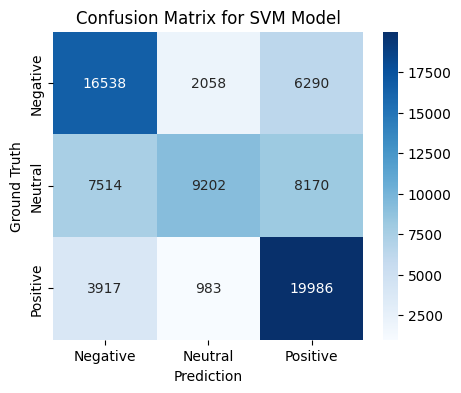

In [60]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_train_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for SVM Model')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show()

## AUC for ROC (Training set)
- Create ROC curve and calculate AUC

### Since, our classification is multi-class, we need to convert the labels to binary.

In [61]:
y_train_binarized = label_binarize(y_train, classes=[0, 1, 2]) # 0, 1, 2 are for negative, 
# neutral, positive as shown in le.classes_
# So each class is represented by a binary vector. EG: [1,0,0] for Negative
num_classes = y_train_binarized.shape[1]
num_classes

3

In [62]:
y_train_proba = svm_model_2.predict_proba(X_train)

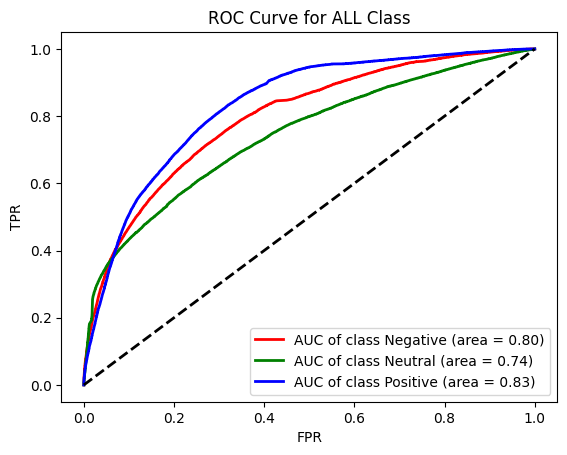

In [63]:
class_names = le.classes_

def plot_roc(binarized, proba, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(num_classes):
        fpr[i], tpr[i], thresholds = roc_curve(binarized[:, i], proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i]) # Add AUC's to dictionary to unpack in next loop

    # Plot ROC curves
    colors = cycle(['red', 'green', 'blue']) # Just the RG and Bees
    for i, color in zip(range(num_classes), colors): # Need to go through all the classes and colors
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='AUC of class {0} (area = {1:0.2f})'
                ''.format(class_names[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=1) # Just the straight line
    plt.title('ROC Curve for ALL Class')
    plt.ylabel('TPR')
    plt.xlabel('FPR')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(y_train_binarized, y_train_proba, num_classes)

## Accuracy and Classification report for training set

In [64]:
y_train_pred = svm_model_2.predict(X_train)
train_report = classification_report(y_train, y_train_pred, target_names=class_names)
print("Training Classification Report:\n", train_report)

Training Classification Report:
               precision    recall  f1-score   support

    Negative       0.59      0.66      0.63     24886
     Neutral       0.75      0.37      0.50     24886
    Positive       0.58      0.80      0.67     24886

    accuracy                           0.61     74658
   macro avg       0.64      0.61      0.60     74658
weighted avg       0.64      0.61      0.60     74658



In [65]:
print("Accuracy:", accuracy_score(y_train, y_train_pred))

Accuracy: 0.612472876316001


## Confusion matrix for testing set

In [66]:
y_pred = svm_model_2.predict(X_test)
confusion_test = confusion_matrix(y_test, y_pred)
confusion_test

array([[ 4702,   630,  1857],
       [ 1890,  2176,  1948],
       [ 4282,  1113, 21402]])

In [67]:
confusion_test_df = pd.DataFrame(confusion_test,
                     index = ['Negative', 'Neutral', 'Positive'], 
                     columns = ['Negative', 'Neutral', 'Positive'])

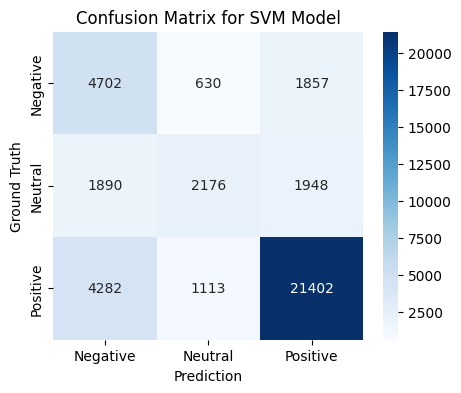

In [68]:
plt.figure(figsize=(5,4))
sns.heatmap(confusion_test_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for SVM Model')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show()

## AUC for ROC (Testing set)

In [69]:
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
y_test_proba = svm_model_2.predict_proba(X_test)

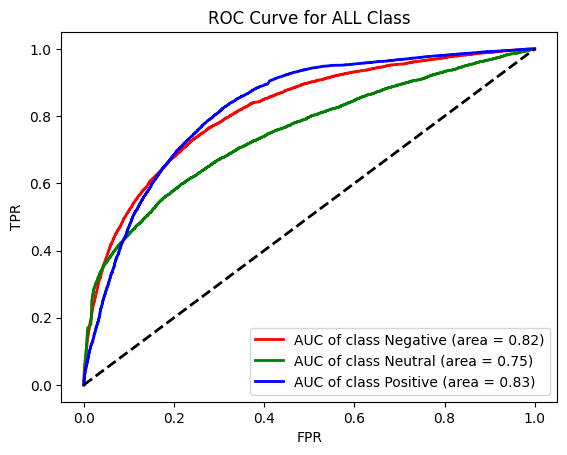

In [70]:
plot_roc(y_test_binarized, y_test_proba, num_classes)

In [71]:
y_test_pred = svm_model_2.predict(X_test)

In [72]:
test_report = classification_report(y_test, y_test_pred, target_names=class_names)
print("\nTesting Classification Report:\n", test_report)


Testing Classification Report:
               precision    recall  f1-score   support

    Negative       0.43      0.65      0.52      7189
     Neutral       0.56      0.36      0.44      6014
    Positive       0.85      0.80      0.82     26797

    accuracy                           0.71     40000
   macro avg       0.61      0.60      0.59     40000
weighted avg       0.73      0.71      0.71     40000



## LIME Interpretability (Testing set)

### Same steps as training model:
> For LIME explanations, let's take the random tweets from the dataset and convert them to embeddings.

> Then, find the predict_probability of that embedding using svc model's predict_proba method.

> Then, we just pass the text from the tweet and predict probability to the exoplainer explain_instance method with number of features to display.

In [73]:
def predict_proba(texts): # Extract embedding using our fasttext model and return the prediction 
    # probability of that    embedding.
    embeddings = np.array([tweet_to_embedding(text, fast_model, top_features) for text in texts])
    return svm_model_2.predict_proba(embeddings) # Prob from svm model 2

In [74]:
lime_explainer = LimeTextExplainer(class_names=le.classes_) # Class names as per the label encoder

for i in range(10):
    try: # Since, we have removed duplicates from the dataset, some indices will not have any tweets.
        rand_idx = random.randint(1, 100000)  # Example index, adjust as necessary
        text_instance = df_cleaned['Tweet'][rand_idx]
    except:
        continue

    exp = lime_explainer.explain_instance(text_instance, predict_proba, num_features=7)
    exp.show_in_notebook(text=True)


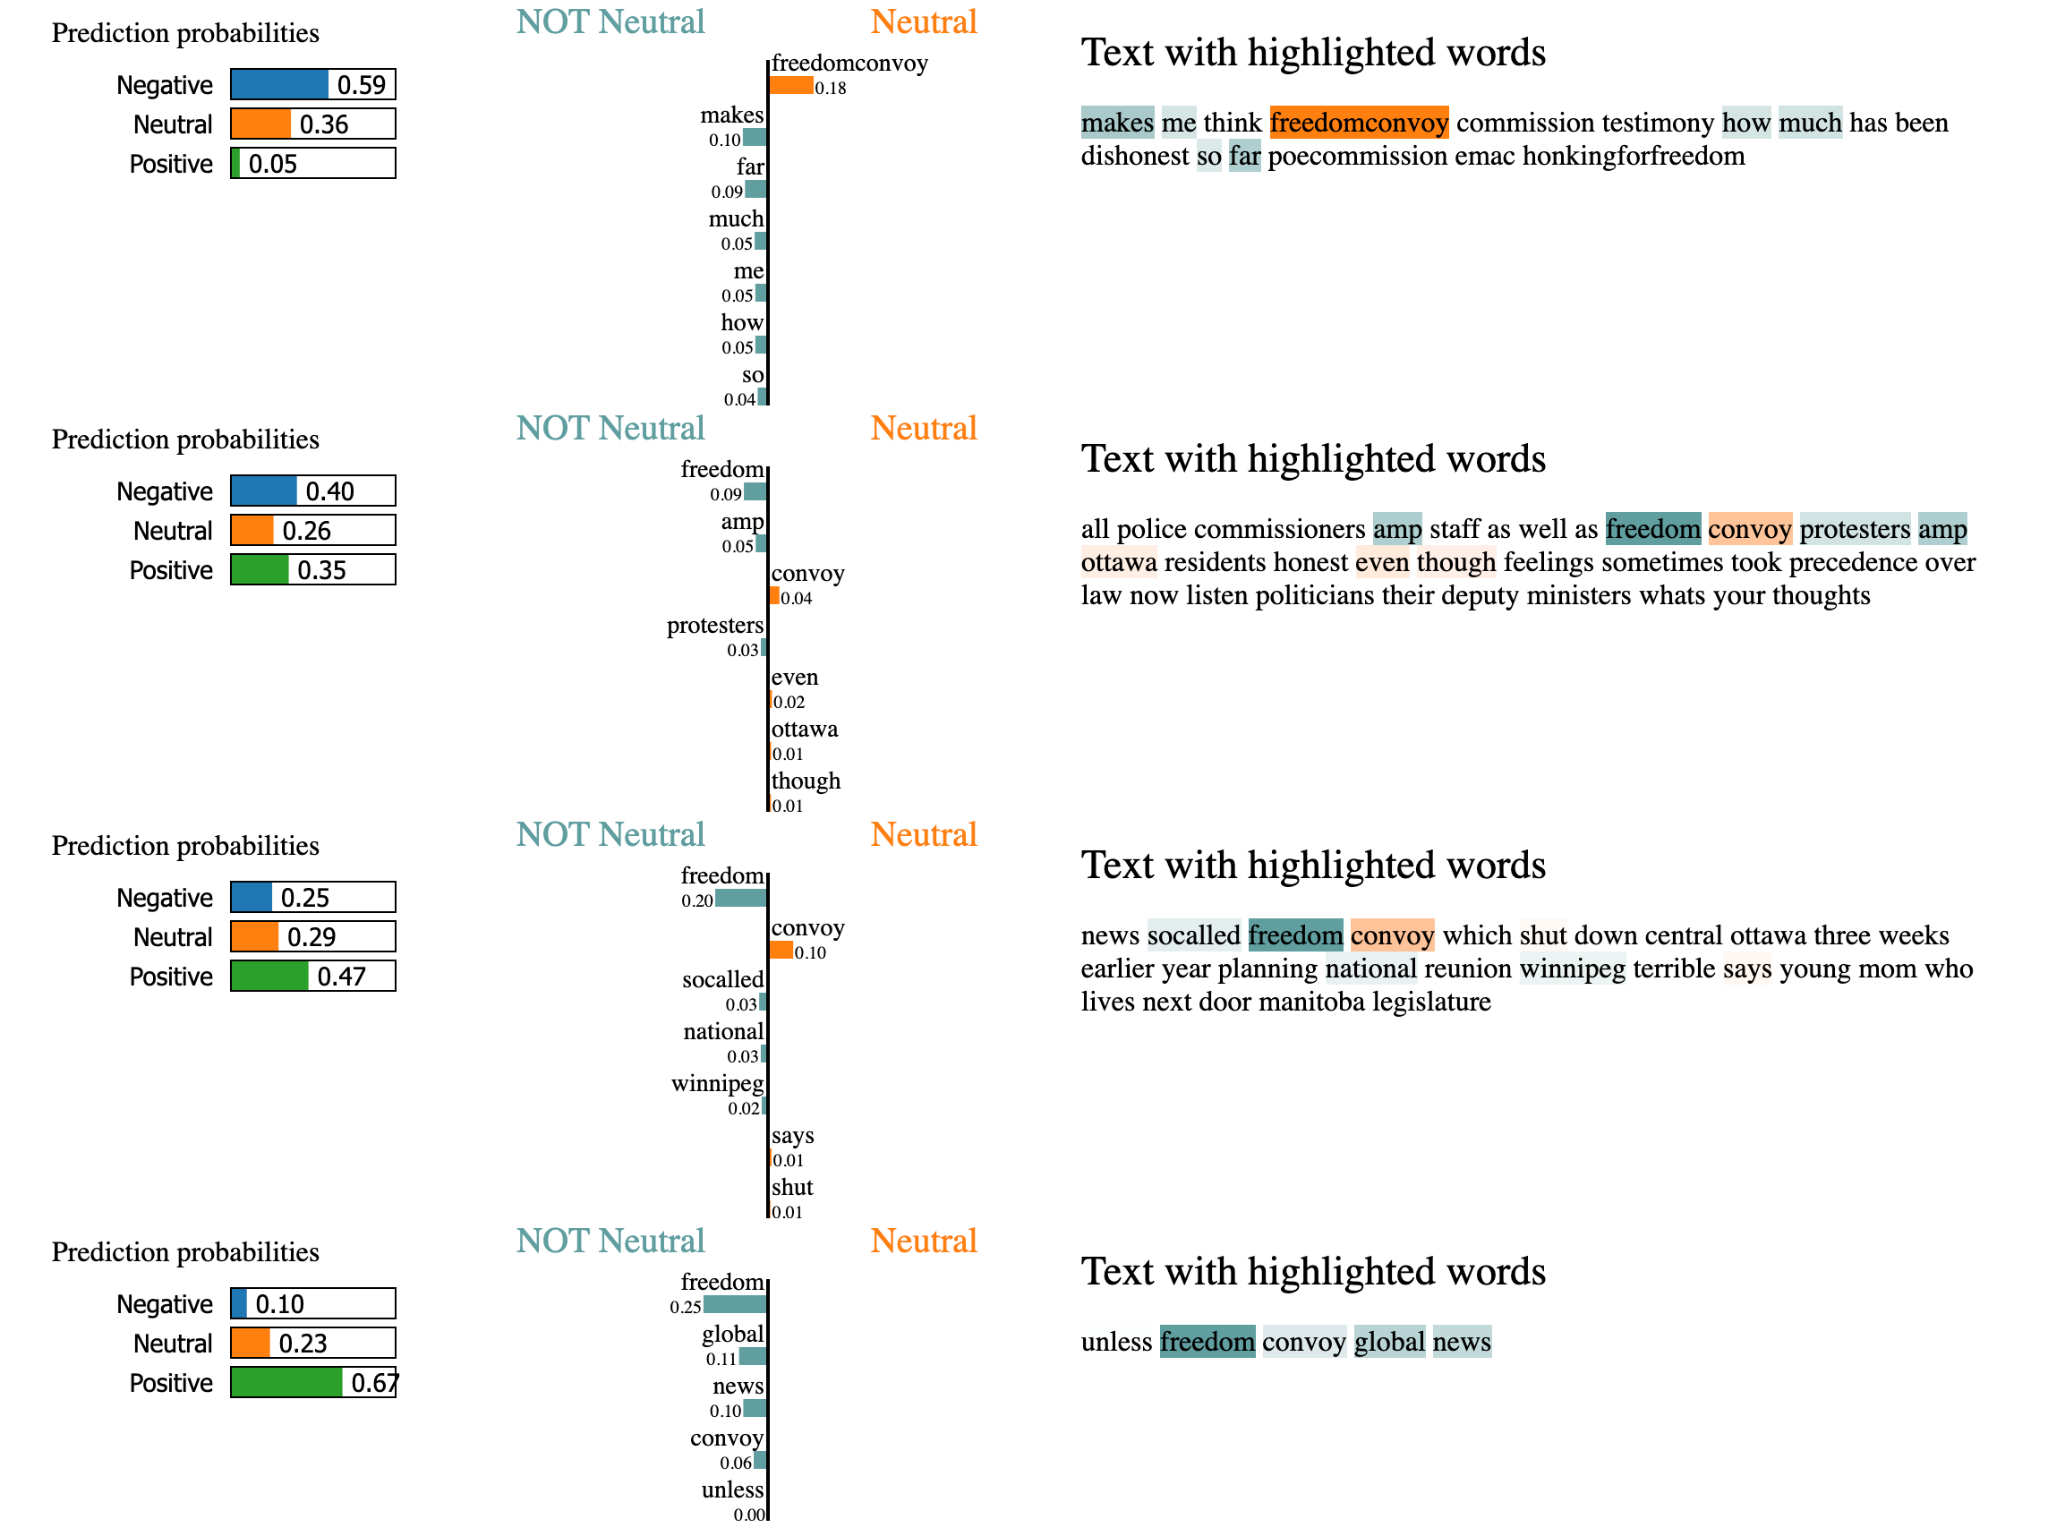

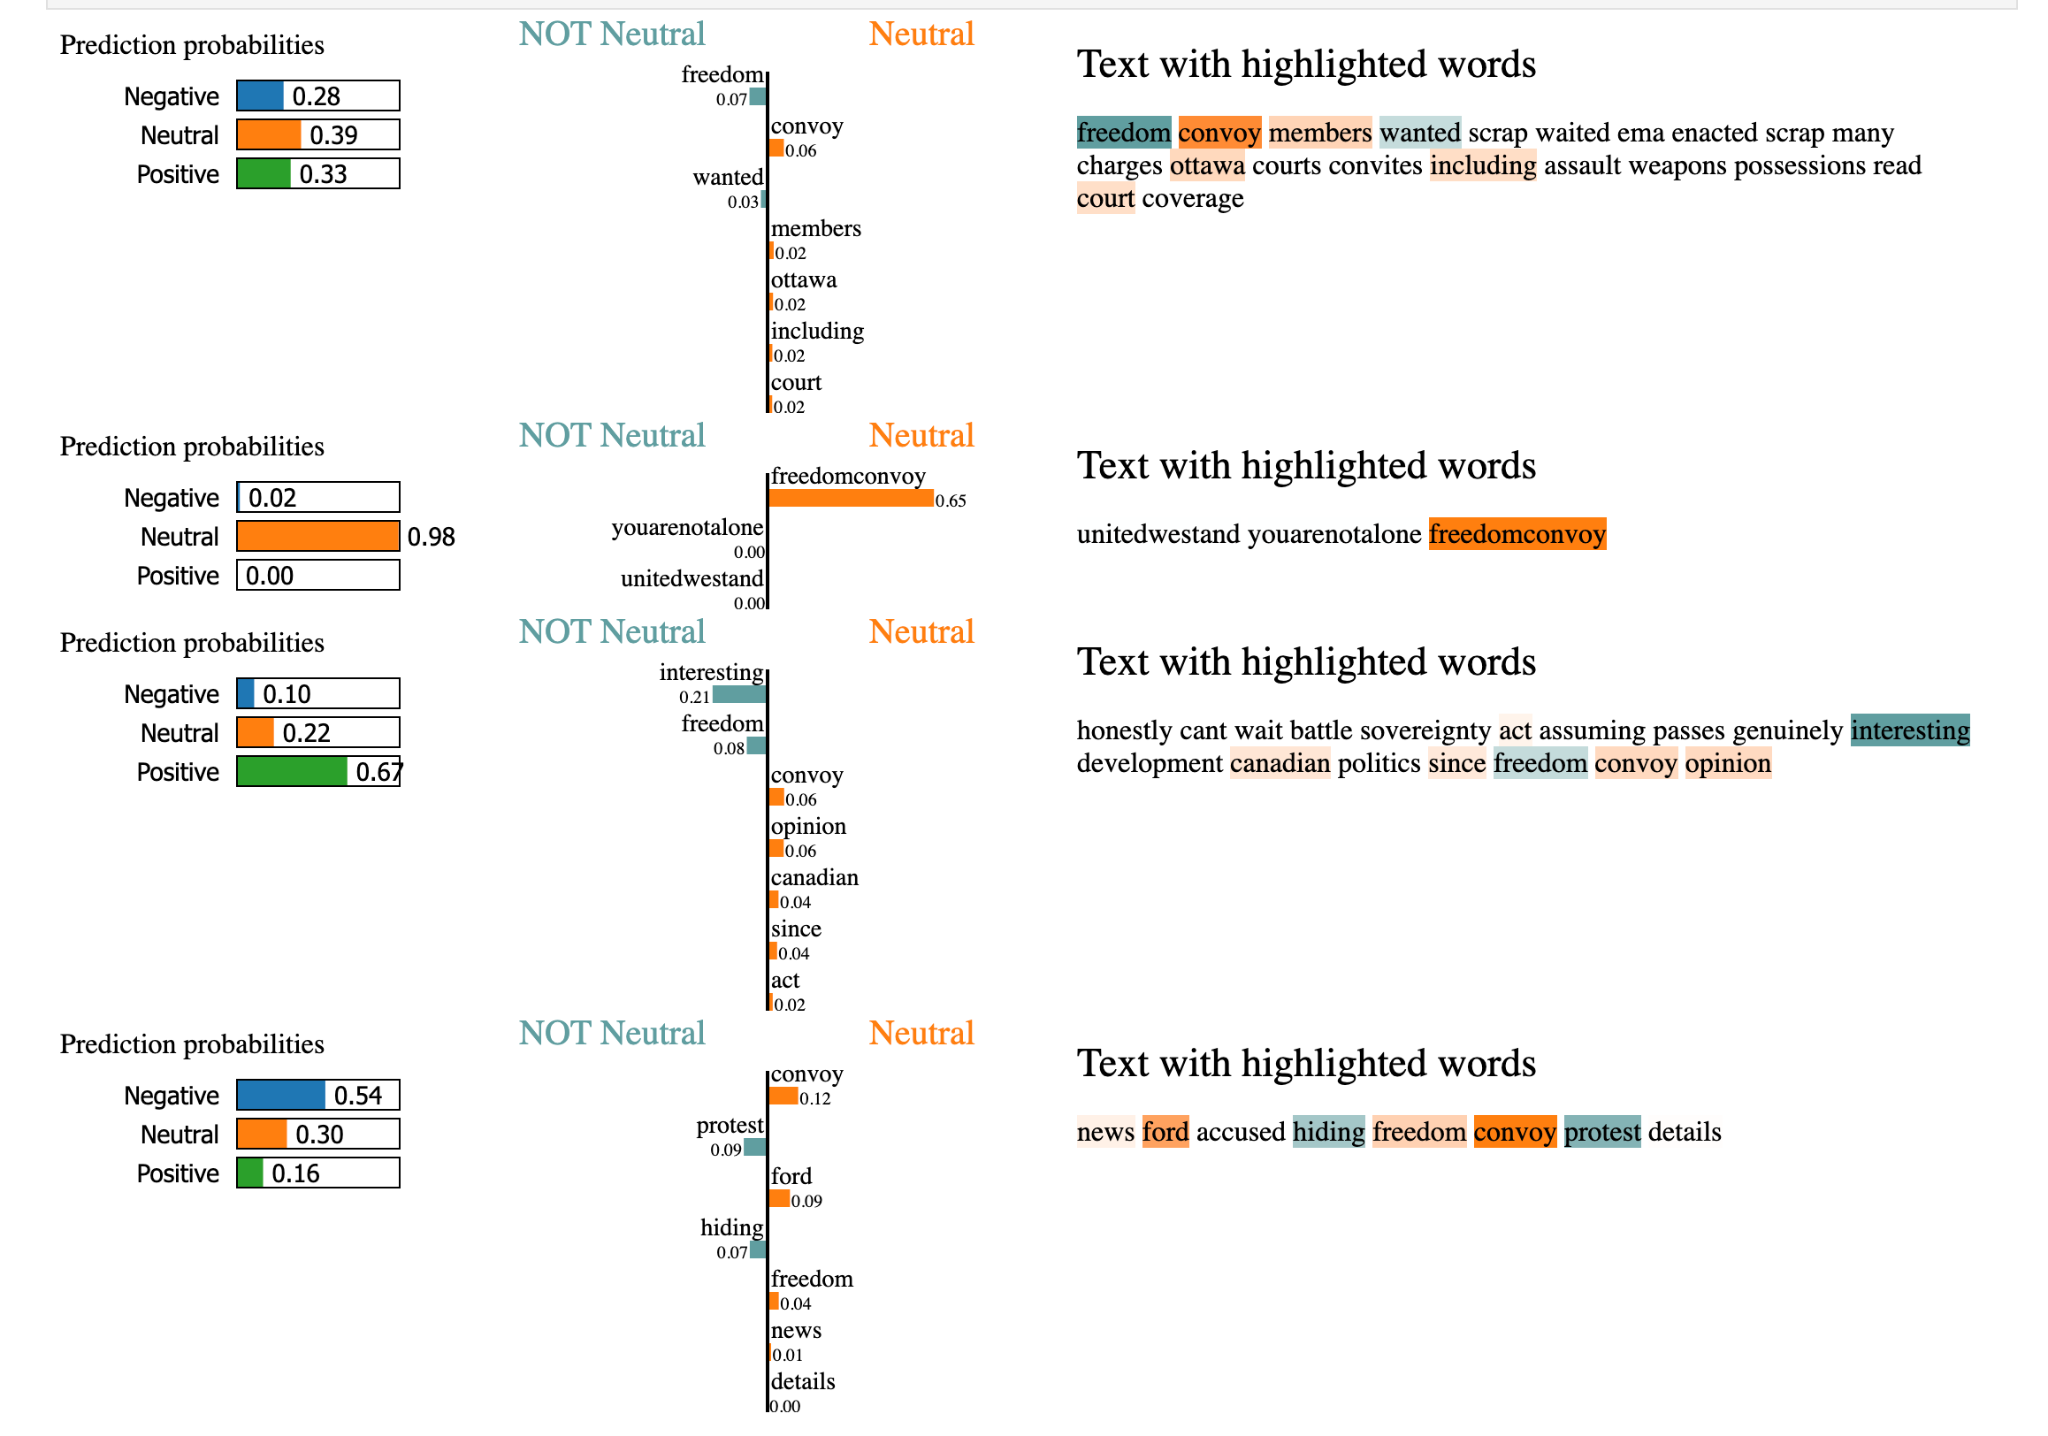

## By looking at the LIME explainers, we can see following things:

> Some words like "interesting", "wanted" and "freedom" have strong influence on the positive class. The model has learnt to give weightage to these kind of adjectives and nouns as the catalyst for positive class.

> The word "protest" has a higher influence on the positive class. Maybe something good came out of protest and the tweet was labeled positive.??

> Words like "dishonest", "so-called", and "terrible" are strong indicators for negative sentiment, which aligns with intuitive understanding of these words 

> Named entities like "Ottawa", "Winnipeg" have less influence on determining the sentiments of the tweets. Maybe we can remove these named entities from the dataset?

# References:

- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
- https://stackoverflow.com/questions/64558402/how-can-i-explain-predictions-of-an-imblearn-pipeline
- https://www.analyticsvidhya.com/blog/2022/07/everything-you-need-to-know-about-lime/
- https://towardsdatascience.com/decrypting-your-machine-learning-model-using-lime-5adc035109b5#:~:text=LIME%20(%20Local%20Interpretable%20Model%2Dagnostic,model%20locally%20around%20the%20prediction.
- https://medium.com/@ginoasuncion/understanding-machine-learning-predictions-with-lime-7892998c7484
- https://contextual-ai.readthedocs.io/en/latest/tutorials/explainer/tutorial_lime_tabular_explainer.html
- https://towardsdatascience.com/lime-how-to-interpret-machine-learning-models-with-python-94b0e7e4432e
- https://github.com/marcotcr/lime
- https://www.kaggle.com/code/prashant111/explain-your-model-predictions-with-lime
- https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights
- https://towardsdatascience.com/a-practical-guide-to-interpreting-and-visualising-support-vector-machines-97d2a5b0564e
- https://stackoverflow.com/questions/45332410/roc-for-multiclass-classification
- https://www.geeksforgeeks.org/multiclass-receiver-operating-characteristic-roc-in-scikit-learn/
- https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
- https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a
- https://stackoverflow.com/questions/59227176/how-to-plot-roc-and-calculate-auc-for-binary-classifier-with-no-probabilities-s
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
- https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
- https://datascience.stackexchange.com/questions/69442/plotting-roc-auc-for-svm-algorithm
- https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
- https://scikit-learn.org/stable/modules/model_evaluation.html
- https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
- https://hersanyagci.medium.com/under-sampling-methods-for-imbalanced-data-clustercentroids-randomundersampler-nearmiss-eae0eadcc145
- https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html
- https://stackoverflow.com/questions/58074021/training-svc-from-scikit-learn-shows-that-using-h-0-may-be-faster
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
- https://dev.to/sunilaleti/don-t-blindly-remove-stopwords-in-sentiment-analysis-3nok
- https://www.researchgate.net/post/Does_Preprocessing_step_Remove_Stop_Word_effect_Sentiment_Analysis_result#:~:text=The%20pre%2Dprocessing%20step%20in,differentiate%20between%20stopwords%20and%20negations.
- https://www.quora.com/Why-sentiment-words-are-in-stopwords-list
- https://ipython.readthedocs.io/en/stable/interactive/magics.html
- https://medium.com/swlh/tweet-sentiment-analysis-using-python-for-complete-beginners-4aeb4456040
- https://fasttext.cc/docs/en/options.html
- https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a
- https://stackoverflow.com/questions/76129814/convert-vector-to-a-word-with-fasttext
- https://stackoverflow.com/questions/43455043/how-to-vectorize-whole-text-using-fasttext
- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html
- https://fasttext.cc/docs/en/unsupervised-tutorial.html
- https://stackoverflow.com/questions/58862684/can-not-render-images-in-ipynb-files-on-vscode
- https://stackoverflow.com/questions/5552555/unicodedecodeerror-invalid-continuation-byte
- https://stackoverflow.com/questions/64706753/how-to-use-pre-trained-word-vectors-in-fasttext
- https://stackoverflow.com/questions/64834159/using-fasttext-word-embedding-with-sklearn-svm
- https://hussainwali.medium.com/revolutionize-your-nlp-projects-with-fasttext-the-ultimate-guide-to-creating-and-using-word-7b8308513b50
- https://blog.devgenius.io/why-and-when-to-use-fasttext-a1cf5641e533
- https://towardsdatascience.com/twitter-sentiment-analysis-using-fasttext-9ccd04465597
- https://medium.com/@kashyapkathrani/all-about-embeddings-829c8ff0bf5b
- https://www.analyticsvidhya.com/blog/2023/01/introduction-to-fasttext-embeddings-and-its-implication/#:~:text=Some%20popular%20word%20embedding%20techniques,the%20FastText%20word%20embedding%20technique.